In [1]:
import itertools
import operator
import sys
import os
import numpy as np
sys.path.append("../src")
from glob import glob
import pandas as pd
import json
from neuraldb.dataset.base_reader import NeuralDatabaseDatasetReader
from neuraldb.dataset.generators.v0_4_database_reader import V4DatabaseSpecificReader
from matplotlib import pyplot as plt

In [3]:
search_root = "/checkpoint/jth/job_staging/neuraldb_expts/experiment=lr_sweep"
checkpoint_name = "metrics_test_distractors*"
files = glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True)


print(len(files))

834


In [11]:
def expand(idx,chunk):
  if idx == 0:
    return ["job_id={}".format(chunk)]
  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  elif chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  elif "=" in chunk:
    return [chunk]

  return []

def parse_file(param):
    bits = param.split("_")
    return {
        "source":bits[3],
        "num": int(bits[4]),
        "try": int(bits[5])
    }
experiments = []

for file in files:
    chunks = file.replace(search_root,"").split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}
    data["file"] = file

    data.update(parse_file(os.path.basename(file)))

    data['dir'] = os.path.dirname(file)
    experiments.append(data)

In [12]:
for experiment in experiments:
    with open(experiment['file']) as f:
        results = json.load(f)

    experiment["EM"] = results['test']["EM"]

    for k,v in results['test']["raw"]["relation_type"].items():
        experiment["breakdown_{}".format(k)] = np.mean(v)

    for k,v in results['test']["raw"]["query_type"].items():
        experiment["query_{}".format(k)] = np.mean(v)

In [14]:
results = pd.DataFrame(experiments).fillna(0)
cols = {col:[np.mean, np.std] for col in filter(lambda col: col == "EM" or col.startswith("breakdown_"),results.columns)}
breakdown_cols = list(filter(lambda col: col.startswith("breakdown_"),results.columns))
breakdown = pd.pivot_table(results, index=["model","context","source"],columns=["num"],aggfunc=cols)
breakdown

EM                                          \
                                 mean                                           
num                             1         10        50        100       1000    
model   context source                                                          
t5-base 100     distractors  0.901333  0.898111  0.889265  0.883870  0.861874   
                similar      0.901606  0.899303  0.886695  0.877706  0.846936   
        1000    distractors  0.926988  0.926453  0.920527  0.916408  0.905179   
                similar      0.927199  0.926371  0.919566  0.916098  0.896272   

                                                                               \
                                                                          std   
num                             2500      5000      7500      10000     1       
model   context source                                                          
t5-base 100     distractors  0.858606  0.849861  0.845213  0.843900  0.005488   
                similar           NaN       NaN       NaN       NaN  0.005310   
        1000    distractors  0.904590  0.899213  0.896851  0.894859  0.001177   
                similar      0.884367  0.879590       NaN  0.867454  0.002164   

                             ... breakdown_spouse                      \
                             ...             mean       std             
num                          ...            10000     1         10      
model   context source       ...                                        
t5-base 100     distractors  ...         0.222885  0.054146  0.063107   
                similar      ...              NaN  0.049256  0.050004   
        1000    distractors  ...         0.082440  0.007492  0.007492   
                similar      ...         0.000000  0.008015  0.008015   

                                                                               \
                                                                                
num                             50        100       1000      2500      5000    
model   context source                                                          
t5-base 100     distractors  0.059724  0.070322  0.066833  0.058619  0.074794   
                similar      0.063272  0.055732  0.051378       NaN       NaN   
        1000    distractors  0.007028  0.007028  0.054021  0.065489  0.042098   
                similar      0.007975  0.055696  0.057307  0.113744  0.062500   

                                                 
                                                 
num                             7500      10000  
model   context source                           
t5-base 100     distractors  0.070616  0.045159  
                similar           NaN       NaN  
        1000    distractors  0.086841  0.115909  
                similar           NaN  0.000000  

[4 rows x 252 columns]

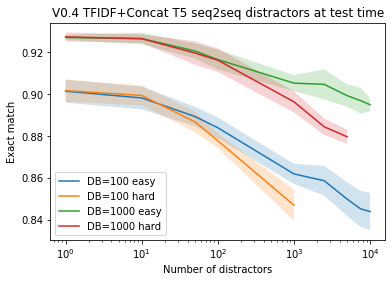

In [45]:
points = [1,10,50,100,1000,2500,5000,7500,10000]
labels =[]
for mod,ty in [("100","distractors"), ("100","similar"),("1000","distractors"),("1000","similar")]:
    means = [breakdown["EM"]["mean"].T["t5-base"].T[a][mod][ty] for a in points]
    stds = [breakdown["EM"]["std"].T["t5-base"].T[a][mod][ty] for a in points]

    upper = [mean+std for mean, std in zip(means,stds)]
    lower = [mean-std for mean, std in zip(means,stds)]

    plt.plot(points,means)
    plt.fill_between(points,lower,upper,alpha=0.2)
    labels.append("DB={} {}".format(mod,"easy" if ty =="distractors" else "hard"))
plt.title("V0.4 TFIDF+Concat T5 seq2seq distractors at test time")
plt.legend(labels)
plt.ylabel("Exact match")
plt.xlabel("Number of distractors")
plt.xscale("log")
plt.show()